In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

import random

import copy
from sklearn.metrics import classification_report, confusion_matrix

import tarfile

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn.metrics import f1_score

from tqdm import tqdm
import wandb

from glob import glob

import cv2 
import time
from datetime import timedelta, datetime
from PIL import Image
import PIL
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


# Accelerate parts
from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
from accelerate.utils import set_seed # reproducability across devices

In [2]:
SEED_VAL = 7
N_CLASSES_main = 1
N_CLASSES_js = 30



def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True
    
seed_everything(SEED_VAL)

order = torch.randint(low = 1, 
                      high = 31,
                      size = ()) 
print(order.item())

16


In [3]:
class Custom_dataset_RainDS(Dataset):
    def __init__(self, 
                 base_folder_path: str,
                 transforms = None,
                 mode: str = "train"):
        self.base_folder_path = base_folder_path
        self.transforms = transforms
        self.mode = mode
        
        fPath_GT = os.path.join(base_folder_path, "gt")
        fPath_rdrop = os.path.join(base_folder_path, "raindrop")
        fPath_rstreak= os.path.join(base_folder_path, "rainstreak")
        fPath_rdrop_rstreak= os.path.join(base_folder_path, "rainstreak_raindrop")
        
        files_list_GT = glob(os.path.join(fPath_GT, "*.png"))
        files_list_rdrop = glob(os.path.join(fPath_rdrop, "*.png"))
        files_list_rstreak = glob(os.path.join(fPath_rstreak, "*.png"))
        files_list_rdrop_rstreak = glob(os.path.join(fPath_rdrop_rstreak, "*.png"))
        
        files_list_GT.sort()
        files_list_rdrop.sort()
        files_list_rstreak.sort()
        files_list_rdrop_rstreak.sort()
        
        self.data = []
        master_SSL_file_list = files_list_GT + files_list_rdrop + files_list_rstreak + files_list_rdrop_rstreak
        print("NUmber of images : ", len(master_SSL_file_list))
        
        for fname in master_SSL_file_list:
            # 0 : 0 degrees
            # 1 : 90 degrees
            # 2 : 180 degrees
            # 3 : 270 degrees
            for i in range(4):
                self.data.append([fname, i])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        fname, class_id = self.data[idx]
        img = cv2.imread(fname) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if class_id == 1:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        if class_id == 2:
            img = cv2.rotate(img, cv2.ROTATE_180)
        if class_id ==3:
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        if self.transforms:
            img = self.transforms(img)
            
        return {"img": img,
                "class_id": class_id}

In [4]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),
        transforms.Resize((224, 224), interpolation=PIL.Image.BILINEAR)
    ])

train_ds =  Custom_dataset_RainDS(base_folder_path = "/kaggle/input/rainds/RainDS/RainDS_real/train_set", 
                                      transforms = image_transforms,
                                      mode = "train")

NUmber of images :  600


In [5]:
idx = 0
img, class_id = train_ds[idx]["img"], train_ds[idx]["class_id"]

In [6]:
print(img.shape)
print(class_id)

torch.Size([3, 224, 224])
0


In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def get_img_by_idx(idx):
    img, _ = train_ds[idx]["img"], train_ds[idx]["class_id"]
    img = torch.unsqueeze(img,0)
    img = denormalize(img, *stats)
    img = torch.squeeze(img, 0)
    img = img.permute(1,2,0).numpy()
    return img

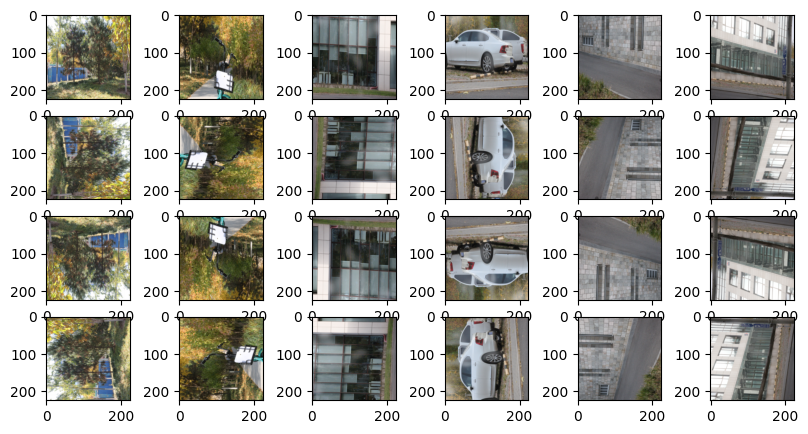

In [8]:
f, axarr = plt.subplots(4,6, figsize = (10,5))
for i in range(6):
    axarr[0,i].imshow(get_img_by_idx(4*i))
    axarr[1,i].imshow(get_img_by_idx(4*i+1))
    axarr[2,i].imshow(get_img_by_idx(4*i+2))
    axarr[3,i].imshow(get_img_by_idx(4*i+3))